We assume you will run this notebook in Colab.  You can do so by clicking on the button below.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/datasci-w266/2023-fall-main/blob/master/materials/walkthrough_notebooks/embeddings_and_rag/1_Embeddings.ipynb)

# An Introduction to Embedding Models

In natural language processing, an embedding model refers to a technique that converts words or phrases into numerical representations, often in the form of dense vectors. These vectors capture semantic relationships between words, allowing NLP models to understand and process textual information more effectively.

The concept of word embeddings is particularly important because traditional NLP methods often treat words as discrete symbols, ignoring the relationships and meanings between them. Word embeddings address this limitation by mapping words to continuous vector spaces where words with similar meanings are located closer to each other.

Word embeddings are trained on large text corpora using techniques like [Word2Vec](https://jalammar.github.io/illustrated-word2vec/), [GloVe (Global Vectors for Word Representation)](https://nlp.stanford.edu/projects/glove/), and [FastText](https://fasttext.cc/docs/en/crawl-vectors.html). These models create dense vector representations where words with similar contexts have similar vectors. For instance, in a good word embedding model, the vectors for "king" and "queen" would be closer together than the vectors for "king" and "cat."

These embeddings are pre-trained on large amounts of text data, and they can be utilized as a fundamental component in various natural language processing tasks like sentiment analysis, machine translation, text generation, and more. Moreover, embeddings can also be fine-tuned for specific tasks using transfer learning techniques, further improving their applicability.

Embedding models are not limited to representing words; they can also be used to represent the semantics of phrases, sentences, and even entire documents. The goal of these embeddings is to represent two sequences of text that say the same thing using different words with similar vectors.  An example from [Universal Sentence Encoders (USE)](https://arxiv.org/pdf/1803.11175.pdf) are the two sentences "How old are you?" and "What is your age?" They share no words in common but the USE generated vectors have a cosine similarity above 0.9. These embeddings, whether for individual words or longer sequences, are crucial in enabling machine learning models to effectively process and understand human language.

This notebook assumes you are familiar with [word embeddings](https://github.com/datasci-w266/2023-fall-main/blob/master/materials/lesson_notebooks/lesson_1_WordEmbeddings_and_Analogies.ipynb).  Here we explore the generation and use of embeddings for longer sequences of text such as phrases, sentences and documents.

There are a number of ways these embessings for longer sequences of text cna be generated.  We already mentioned the USE model.  It's also possible to use pretrained [sentence transformers](https://github.com/UKPLab/sentence-transformers) to generate them.  Because they are a powerful representation, commercial large language models also offer endpoints that will generate an embedding given a sequence of input text. These embeddings can be used in a variety of downstream NLP tasks ranging from classification to retrieval.  While it is typical to introduce a generative model like those in the GPT family with a specific embedding model, they are not necessarily coupled.  This is something we explore in the notebooks that follow this one.

# OpenAI and Cohere Accounts and API Endpoints

OpenAI and Cohere provide large language models.  This notebook uses API endpoints from each.  

OpenAI provides free, rate-limited usage to its API endpoint for a three-month trial period.  In order to use the OpenAI API endpoint you will need an OpenAI API token.

Cohere provides free, rate-limited usage for learning and prototyping. In order to use Cohere you will need a Cohere API token.

If you don't already have an OpenAI API token you can get one by signing up for a free OpenAI account from the [OpenAI Signup page](https://platform.openai.com/signup?launch).  Once you have created your OpenAI account you can create a trial API key from the [OpenAI API page](https://platform.openai.com/account/api-keys).

If you don't already have a Cohere API token you can get one by signing up for a Cohere account from the [Cohere dashboard](https://dashboard.cohere.ai).  Once you have created your Cohere account you can create a trial API key from the [Cohere API Keys page](https://dashboard.cohere.ai/api-keys).

# Setup

## Environment Related Helpers

This portion of the notebook includes `install_if_needed` which will install a single package or list of packages with `pip` only if necessary, and `running_in_colab` a predicate that returns `True` if the notebook is running in Google Colab.

In [ ]:
import importlib


def install_if_needed(package_names):
    """
    Install one or more Python packages using pip if they are not already installed.

    Args:
        package_names (str or list): The name(s) of the package(s) to install.

    Returns:
        None
    """
    if isinstance(package_names, str):
        package_names = [package_names]

    for package_name in package_names:
        try:
            importlib.import_module(package_name)
            print(f"{package_name} is already installed.")
        except ImportError:
            !pip install --quiet {package_name}
            print(f"{package_name} has been installed.")


def running_in_colab():
    """
    Check if the Jupyter Notebook is running in Google Colab.

    Returns:
        bool: True if running in Google Colab, False otherwise.
    """
    try:
        import google.colab

        return True
    except ImportError:
        return False

## Mount Google Drive

By default, the data you create in Google Colaboratory does not persist from session to session.  Each session runs in a virtual machine and when that machine goes away, so does your data.  If you want your data to persist, you must store it outside the virtual machine. Google Drive can be used for that purpose.  We use it later in this notebook to store the OpenAI and Cohere API keys.

In [ ]:
if running_in_colab():
    from google.colab import drive

    drive.mount("drive")

Mounted at drive


## Python-dotenv

`Python-dotenv` is a Python module that allows you to specify environment variables in traditional UNIX-like “.env” (dot env) file within your Python project directory.

Environment variables are key-value pairs for the current user environment. They are generally set by the operating system and the current user-specific configurations.

`Python-dotenv` allows the user to work with API keys without exposing them to the outside world.

In [ ]:
install_if_needed("python-dotenv")

python-dotenv has been installed.


## Add API Keys to .env File

The format of a .env file is simple: each line contains a single key-value pair, with the key and value separated by an equal sign (=). Here's an example:
```
DATABASE_URL=your_database_url
API_KEY=your_api_key
DEBUG=True
```
To use OpenAI and Cohere, we need to set the `OPENAI_API_KEY` and `COHERE_API_KEY` environment variables, which means the `.env` file should have lines that looks like:
```
OPENAI_API_KEY=your_openai_api_key_value
COHERE_API_KEY=your_cohere_api_key_value
```
One way to do that is to create or edit the `.env` file directly.  As with most Unix systems, file names that begin with a `.` in Google Drive are hidden from display, but you can still access them. For example, if you enter the name `.env` in the Google Drive search bar, you will be able to access your `.env` file (if it exists).

You can use the `append_key_to_env` helper function included below.  If used without arguments it will prompt the user for the value of an OpenAI API key and then the value of a Cohere API key and append each with the correct key name to the `.env` file in the root of the users Google Drive folder or current working directory if not running in Colab.  It will create the `.env` file if necessary.  You can provide an alternate list of key names and an alternate path to the `.env` file if you desire, but the defaults are fine for this notebook.

Once the OpenAI and Cohere APIs key have been stored in the `.env` file you should not need to do anything else with that file.  If either of your keys change you will need to update the `.env` file.

In [ ]:
import os
import getpass

from dotenv import load_dotenv, find_dotenv


def env_file_path(
    colab_path="/content/drive/MyDrive/.env", other_path=f"{find_dotenv()}"
):
    """
    Returns the appropriate file path for the environment variables file (.env) based on the execution environment.

    This function is designed to determine the correct path for the environment variables file
    depending on whether the code is running in Google Colab or in a different environment.

    Args:
        colab_path (str, optional): The file path for the environment variables file in Google Colab.
            Default is '/content/drive/MyDrive/.env'.

        other_path (str, optional): The file path for the environment variables file in other environments.
            Default is '/workspace/.env'.

    Returns:
        str: The file path for the environment variables file (.env).
    """

    return colab_path if running_in_colab() else other_path


def append_key_to_env(
    env_file_path=env_file_path(), key_names=["OPENAI_API_KEY", "COHERE_API_KEY"]
):
    with open(env_file_path, "a") as env_file:
        for key_name in key_names:
            key_value = getpass.getpass(f"Please enter the value for {key_name}: ")
            env_file.write(f"{key_name}={key_value}\n")

In [ ]:
# Remove the # character in the line below and run if desired
# append_key_to_env()

Please enter the value for OPENAI_API_KEY: ··········
Please enter the value for COHERE_API_KEY: ··········


## Load the API Keys

The following cell loads the OpenAI and Cohere API keys into the current environment.

In [ ]:
load_dotenv(env_file_path())
OPENAI_API_KEY = os.environ["OPENAI_API_KEY"]
COHERE_API_KEY = os.environ["COHERE_API_KEY"]

## GPU Support (Optional)

In [ ]:
import tensorflow as tf

print("GPU Available:", tf.config.list_physical_devices("GPU"))

GPU Available: []


In [ ]:
install_if_needed("torch")
import torch

print("CUDA Available:", torch.cuda.is_available())

torch is already installed.
CUDA Available: False


# Langchain

LangChain is a framework designed to simplify the creation of NLP applications using large language models as part of their processing pipeline. As a language model integration framework, LangChain's use-cases largely overlap with those of language models in general, including document analysis and summarization, chatbots, and code analysis.

The examples in this notebook collection often use LangChain rather than the underlying Python modules.  However, when the LangChain abstraction obscures underlying elements of interest, we use the relevant Python module directly. A description of LangChain is beyond the scope of this notebook collection.

In [ ]:
install_if_needed("langchain")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 13.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.0/40.0 kB 4.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.4/49.4 kB 5.6 MB/s eta 0:00:00
langchain has been installed.


# Embedding Models

We will use OpenAI and Cohere large language models, including their embedding models.  We will also use embedding models from the SentenceTransformers collection.  The first two notebooks in this collection make use of embedding models only.  The generative models come into play when we get to the third notebook, which is about question answering.

An overview of OpenAI models can be found [here](https://platform.openai.com/docs/models/overview) and an overview of OpenAI embeddings can be found [here](https://platform.openai.com/docs/guides/embeddings/what-are-embeddings).

An overview of Cohere models and embeddings can be found [here](https://docs.cohere.com/docs/models).

An overview of SentenceTransformers can be found [here](https://sbert.net).  SentenceTransformers was created by Nils Reimers.  Nils is now the Director of Machine Learning at Cohere.

In [ ]:
packages = [
    "openai",
    "cohere",
    "tiktoken",
    "transformers",
    "sentence_transformers",
    "seaborn",
    "matplotlib",
]
install_if_needed(packages)

import seaborn as sns
import matplotlib.pyplot as plt

import openai, tiktoken
from langchain.embeddings.openai import OpenAIEmbeddings
from langchain.embeddings.cohere import CohereEmbeddings

import cohere

from langchain.embeddings import HuggingFaceEmbeddings
from transformers import AutoTokenizer

from sklearn.metrics.pairwise import cosine_similarity

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.0/77.0 kB 2.5 MB/s eta 0:00:00
openai has been installed.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.6/47.6 kB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 17.8 MB/s eta 0:00:00
cohere has been installed.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 14.8 MB/s eta 0:00:00
tiktoken has been installed.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 28.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 31.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 71.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 63.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 29.2 MB/s eta 0:00:00
transformers has been installed.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 2.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 

The default OpenAI model is `text-embedding-ada-002`, which is the preferred OpenAI embedding model for its GPT 3.5 and GPT 4 models.  The context length for the model is 8192 tokens.  For more information see the OpenAI [blog announcement](https://openai.com/blog/new-and-improved-embedding-model).

The default Cohere model is `embed-english-v2.0`  The maximum number of tokens for the model is `512`.

The SentenceTransformers model `paraphrase-multilingual-mpnet-base-v2` is based on the `xlm-roberta-base` model.  It is trained on more than fifty languages. The maximum number of tokens for this model is `128`.  We use it here because of its multilingual capability.  Many of the embedding models available from the [SBERT](https://sbert.net/docs/pretrained_models.html) site have a `512` token maximum.

Next, we instantiate our embedding models and some useful utility functions.

In [ ]:
openai_embeddings_model = OpenAIEmbeddings()
openai_embeddings_model.model

'text-embedding-ada-002'

In [ ]:
cohere_embeddings_model = CohereEmbeddings(truncate="None")
cohere_embeddings_model.model

'embed-english-v2.0'

In [ ]:
sbert_model_name = "paraphrase-multilingual-mpnet-base-v2"
sbert_embeddings_model = HuggingFaceEmbeddings(model_name=sbert_model_name)
sbert_tokenizer = AutoTokenizer.from_pretrained(
    f"sentence-transformers/{sbert_model_name}"
)

In [ ]:
def openai_token_count(text):
    embedding_model = OpenAIEmbeddings()
    openai_encoding = tiktoken.encoding_for_model(embedding_model.model)
    return len(openai_encoding.encode(text))


cohere_client = cohere.Client(COHERE_API_KEY)


def cohere_token_count(text, model_name="command", client=cohere_client):
    return len(cohere_client.tokenize(text=text, model=model_name))


def sbert_token_count(text, tokenizer=sbert_tokenizer):
    return len(tokenizer(text, add_special_tokens=False).input_ids)


def embeddings_similarity_heatmap(embeddings, figsize=None):
    if figsize is None:
        figsize = (len(embeddings), len(embeddings))
    similarity_matrix = cosine_similarity(embeddings)
    plt.figure(figsize=figsize)
    sns.heatmap(cosine_similarity(embeddings), vmin=0.1, vmax=1.0, cmap="viridis", annot=True, fmt=".3f")

## Short Strings

Let's create OpenAI, Cohere and SBERT embeddings from a series of strings, calculate pairwise cosine similarity and look at some heatmaps of the results.  Ideally, the first three strings will be close to each other, then the next two, and finally the last three.

While all three sets of embedding endpoints achieve that, the OpenAI embeddings do not do as good a job at distinguishing the three clusters from each other compared to the Cohere and Sentence Transformers embedding models.  The groupings and distinctions seem especially clear with the Sentence Transformer model.  This may be because the Sentence Transformer is desiged to work with sentences while OpenAI and Cohere are designed to work with longer sequences of text.

In [ ]:
strings = [
    "That movie was great.",
    "That film was wonderful.",
    "That movie was awesome.",
    "That film was rotten.",
    "That show was garbage.",
    "Grab a snapshot of the trash",
    "Take a picture of that rubbish.",
    "Film the garbage.",
]

openai_embeddings = openai_embeddings_model.embed_documents(strings)
cohere_embeddings = cohere_embeddings_model.embed_documents(strings)
sbert_embeddings = sbert_embeddings_model.embed_documents(strings)

Note that each one of these models uses a different tokenizer or subword model.  Sometimes this is implicit, meaning you pass in a string and it tokenizes for you.  Sometimes you need to run the tokenizer and send its output to the endpoint.  Please be aware of whether your endpoint expects pre-tokenized inputs and be sure to use the correct tokenizer.  You can see in the three cells below how many tokens are generated for each of our three endpoints.

In [ ]:
[openai_token_count(string) for string in strings]

[5, 5, 5, 5, 5, 6, 7, 4]

In [ ]:
[cohere_token_count(string) for string in strings]

[5, 5, 5, 5, 5, 6, 7, 4]

In [ ]:
[sbert_token_count(string, sbert_tokenizer) for string in strings]

[5, 5, 5, 6, 7, 8, 9, 6]

Now we can take the embeddings that we've generated for our 8 sentences and generate a heatmap that shows how well the three groups of sentences are distinguished.  Again the expectation is that the first three sentences should be very similar, the next two should be similar to each other, and the final three should be most similar to each other.

### OpenAI

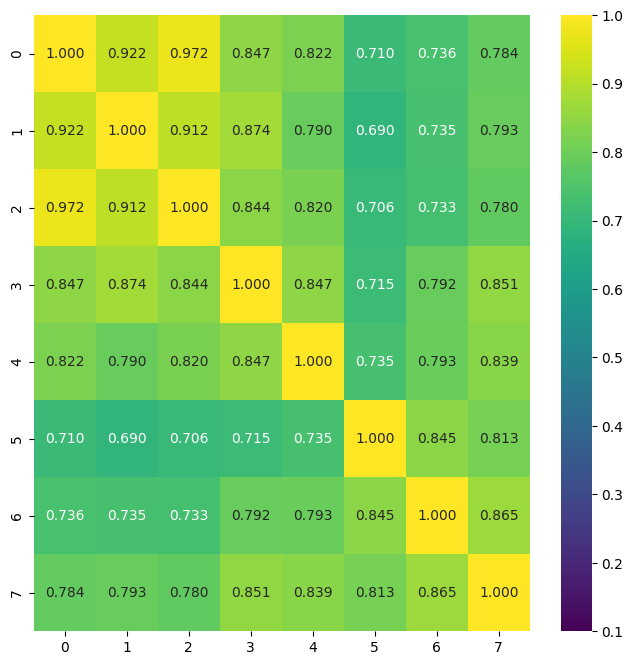

In [ ]:
embeddings_similarity_heatmap(openai_embeddings)

### Cohere

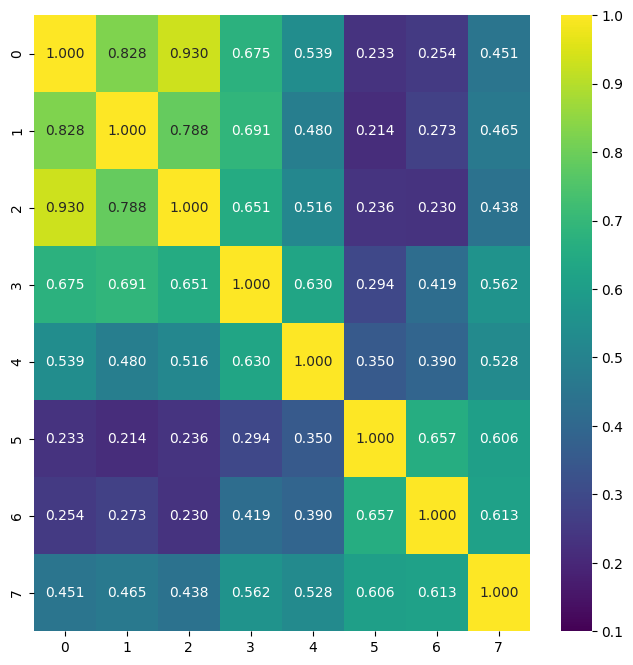

In [ ]:
embeddings_similarity_heatmap(cohere_embeddings)

### Sentence Transformers

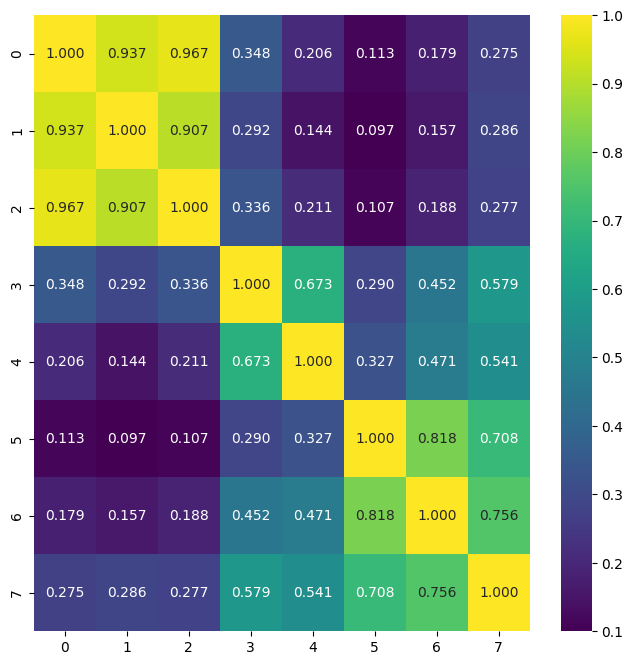

In [ ]:
embeddings_similarity_heatmap(sbert_embeddings)

## Multilingual Embeddings

Ideally we use embeddings to capture semantic similarity between sequences.  We've seen this work with sentences all in the same language.  If we use multilingual models to generate the embeddings, what happens when we look at the same text in several languages.  Will our embeddings reflect the semantic similarity across languages?

Let's examine "Mary had a little lamb" in English, French and Spanish.

In [ ]:
mary_english = """Mary had a little lamb,
Little lamb, little lamb,
Mary had a little lamb,
Its fleece was white as snow

Everywhere that Mary went,
Mary went, Mary went,
Everywhere that Mary went
The lamb was sure to go.

It followed her to school one day
School one day, school one day
It followed her to school one day
Which was against the rules.

It made the children laugh and play,
Laugh and play, laugh and play,
It made the children laugh and play
To see the lamb at school

And so the teacher turned it out,
Turned it out, turned it out,
And so the teacher turned it out,
But still it lingered near
"""

mary_french = """Mary avait un petit agneau,
Un petit agneau, un petit agneau,
Mary avait un petit agneau,
C'est toison était blanche comme neige, ouais

Partout, les Mary est allé,
Mary est allé, Mary est allé
Partout, les Mary est allé
Le petit agneau était sûr d'aller, ouais

Il la suivit à l'école un jour
A l'école un jour, à l'école un jour
Il la suivit à l'école un jour
Et enfreint la règle des enseignants.

Il a fait les enfants rient et jouent,
Rire et jouer, rire et jouer,
Il a fait les enfants rient et jouent
Pour voir un agneau à l'école

Et si l'enseignant il s'est avéré,
Il s'est avéré, il s'est avéré,
Et si l'enseignant il s'est avéré,
Mais toujours il resta près de
"""

mary_spanish = """Mary tenía un pequeño cordero,
Pequeño cordero, pequeño cordero
Mary tenía un pequeño cordero
Su lana era blanca como la nieve como la nieve blanca.

A cualquier lado que Mary iba
Mary iba, Mary iba
A cualquier lado que Mary iba
El cordero atrás yendo iba

Un día a la escuela la siguió
A la escuela un día, a la escuela un día
Un día a la escuela la siguió
Y eso estaba en contra de las reglas de la misma.

Hizó a los niños reír y jugar,
Reír y jugar, reír y jugar
Hizó a los niños reír y jugar
De verlo en la escuela estar.

Y entonces la maestra lo alejó,
Lo alejó, lo alejó
Y entonces la maestra lo alejó
Pero sin embargo cerca permanecía.
"""

mary = [mary_english, mary_french, mary_spanish]
mary_openai_embeddings = openai_embeddings_model.embed_documents(mary)
mary_cohere_embeddings = cohere_embeddings_model.embed_documents(mary)
mary_sbert_embeddings = sbert_embeddings_model.embed_documents(mary)

In [ ]:
[openai_token_count(string) for string in mary]

[143, 212, 218]

In [ ]:
[cohere_token_count(string) for string in mary]

[160, 284, 260]

In [ ]:
[sbert_token_count(string) for string in mary]

[145, 205, 168]

The OpenAI embeddings for the three renditions are similar.

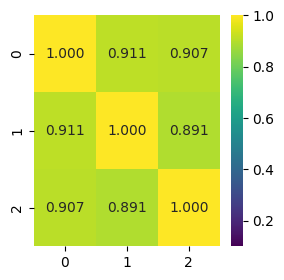

In [ ]:
embeddings_similarity_heatmap(mary_openai_embeddings)

The Cohere embeddings are not similar.  That's not surprising since it's an English only model.

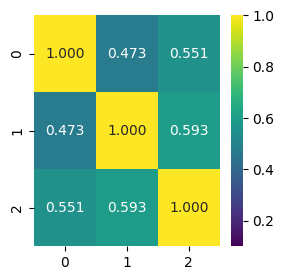

In [ ]:
embeddings_similarity_heatmap(mary_cohere_embeddings)

The Sentence Transformer embeddings are similar and appear to be closer than the OpenAI embeddings.  This particular model (`paraphrase-multilingual-mpnet-base-v2`) is a multilingual model.  Therefore the performance is not surprising.

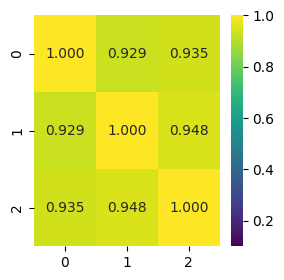

In [ ]:
embeddings_similarity_heatmap(mary_sbert_embeddings)

Cohere has a separate embedding model that provides multilingual embedding suport.  Unlike the `embed-english-v2.0` model which has a `512` token maximum, the `embed-multilingual-v2.0` model has a `256` token maximum.  See [Cohere multilingual language models](https://docs.cohere.com/docs/multilingual-language-models)

The Cohere multilingual model is much stronger on this example, but not as strong as the Sentence Transformer model we looked at above.

In [ ]:
cohere_multilingual_embeddings_model = CohereEmbeddings(
    model="embed-multilingual-v2.0", truncate="End"
)

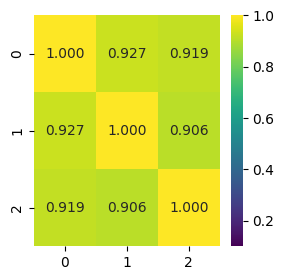

In [ ]:
mary_cohere_multilingual_embeddings = (
    cohere_multilingual_embeddings_model.embed_documents(mary)
)
embeddings_similarity_heatmap(mary_cohere_multilingual_embeddings)

Let's add "Three Blind Mice", in English and compare the OpenAI and Sentence Transformer multilingual embeddings.  Once again, while both seem to work, the Sentence Transformer embeddings seem better for this example.  The similar passagse are more tightly grouped and the outlier is further away.

In [ ]:
mice = """Three blind mice, three blind mice
See how they run, see how they run
They all run away from the farmer's wife
Then into a space ship to take a ride
Did you ever see such a sight in your life
As three blind mice?

Three blind mice, three blind mice
Crash on the moon, crash on the moon
The moon was covered in cheese so high
And nobody knew the reason why
Did you ever see such a sight in your life
As three blind mice?

Three blind mice, three blind mice
With full tummies, with full tummies
All of them ate too much cheese that night
With little moon left after every bite
Did you ever see such a sight in your life
As three blind mice?"""

In [ ]:
openai_token_count(mice)

159

In [ ]:
sbert_token_count(mice)

159

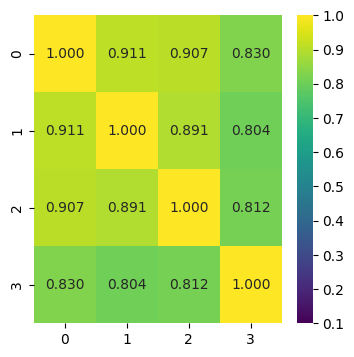

In [ ]:
mary_mice_openai_embeddings = openai_embeddings_model.embed_documents(mary + [mice])
embeddings_similarity_heatmap(mary_mice_openai_embeddings)

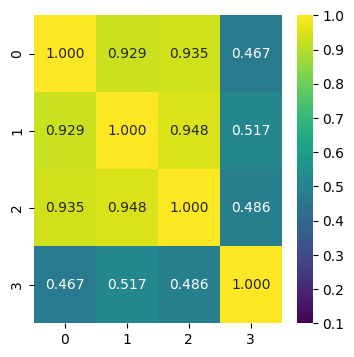

In [ ]:
mary_mice_sbert_embeddings = sbert_embeddings_model.embed_documents(mary + [mice])
embeddings_similarity_heatmap(mary_mice_sbert_embeddings)

What happens when we add some music lyrics to the mix?  As we have seen in the prior examples, the OpenAI embeddings don't seem to do as good a job at separating the examples as the Sentence Transformer embeddings do.

In [ ]:
bohemian = """I see a little silhouetto of a man
Scaramouche, Scaramouche, will you do the Fandango?
Thunderbolt and lightning, very, very frightening me
(Galileo) Galileo, (Galileo) Galileo, Galileo Figaro, magnifico
But I'm just a poor boy, nobody loves me
He's just a poor boy from a poor family
Spare him his life from this monstrosity"""

In [ ]:
openai_token_count(bohemian)

97

In [ ]:
sbert_token_count(bohemian)

94

### OpenAI

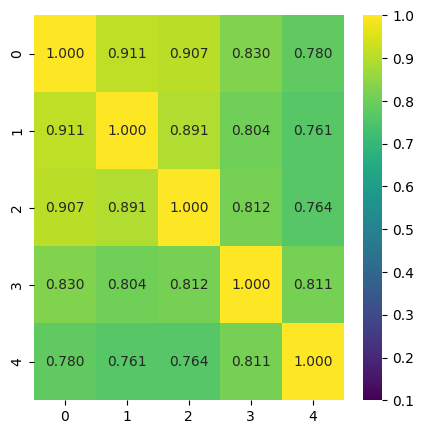

In [ ]:
amalgam_openai_embeddings = openai_embeddings_model.embed_documents(
    mary + [mice, bohemian]
)
embeddings_similarity_heatmap(amalgam_openai_embeddings)

### Sentence transformers

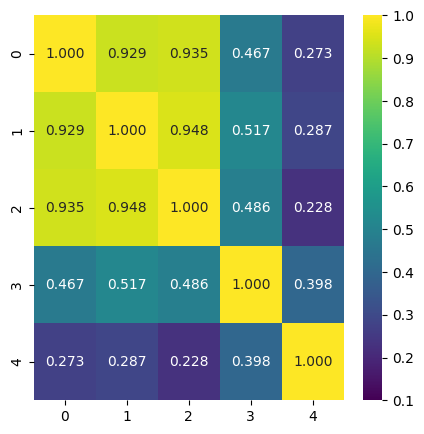

In [ ]:
amalgam_sbert_embeddings = sbert_embeddings_model.embed_documents(
    mary + [mice, bohemian]
)
embeddings_similarity_heatmap(amalgam_sbert_embeddings)

Let's pause before we move on to vector databases.  Our examples, while more than a sentence long, are still relatively short passages.  However, we often want to work with collections of text that are much longer than can be captured in an embedding.  This could be a meaningful issue if the embedding capacity is on the lower end of the range.  The SBERT multilingual embeddings we looked at can only handle `128` tokens.  The Cohere multilingual embeddings get to `256` tokens and if we use the Cohere english only embeddings we get to `512`.  On the other hand, the OpenAI embeddings have a maximum context length of `8192` tokens.  The difference is dramatic.

If your text is short, you may not be concerned.  But if your text sequences are well beyond the capacity of your embedding model then you will need to consider the consequences.  Do you truncate your text because you believe the truncated part captures the essence of what you care about?  Will you split your text into chunks and hope that what you care about is captured in a single chunk and not split across several chunks?  If you go with large embeddings, do you think they will capture enough detail for your use?  These are all important considerations and your decisions will depend on your use case, the size of the passages you work with and the semantic complexity.